# Analysis of precipitation data using extreme value methods

This notebook demonstrates several methods for assessing the frequency of extreme precipitation events.

It is important to remember that when we are studying extreme events using statistical analysis, we are not aiming to classify individual events as being extreme or non-extreme.  Instead, we are aiming to characterize the tail of the probability distribution of event sizes.  This tail reveals the long-run propensity to produce very large events, and determines statistical properties such as the frequencies of records (the largest value yet seen).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme
from scipy.optimize import minimize
from scipy.special import gamma
from pathlib import Path
import lmom

Below we define several functions that implement methods for extreme value analysis.  After defining these functions, we can use them to analyze the precipitation data.

In [2]:
def tail_shape(z, p0=0.1, family="powerlaw"):
    """
    Returns values x, p such that the slope of p on x estimates the
    shape parameter (tail index) of a distribution with power-law
    tails (if family='powerlaw'), or the rate parameter of a
    distribution with exponential tails (if family='exponential').
    The upper p0 fraction of the data in z are used to produce (x, p).
    The returned values in x are the order statistics of z in the
    exponential case, and the log order statistics of z in the powerlaw
    case. The returned values in p are derived from probability
    points.  Scatterplot p against x to get a visualization of the
    tail shape.
    """

    if family not in ["exponential", "powerlaw"]:
        raise ValueError("Unknown family %s" % family)

    z = z.copy()
    p = 1 - p0
    z = np.asarray(z)
    z.sort()
    n = len(z)
    m = int(np.around(p*n))
    x = z[m-1:]
    if family == "powerlaw":
        x = np.log(x + 1e-6)
    p = np.log(1 - np.arange(m, n+1) / (n+1))
    return x, p

In [3]:
def fit_tail_reg(x, ax, p0=0.99, family="powerlaw"):
    """
    Use least squares regression in the upper 'p0' fraction of the right
    tail of a quantile plot to estimate the shape parameter, and add the
    best fit line to the plot in axes 'ax'.
    """

    x, p = tail_shape(x, p0=p0, family=family)

    ax.plot(x, p, color="orange")

    # Estimate the tail index using a least squares fit to the order
    # statistics.
    alpha_hat = -np.cov(p, x)[0, 1] / np.var(x)
    icept = p.mean() + alpha_hat*x.mean()

    # The coordinates of the best-fit line
    xx = np.asarray([x.min(), x.max()])
    yy = icept - alpha_hat*xx

    ax.plot(xx, yy, color="purple")

    return icept, alpha_hat

In [4]:
def hill(z, k=200):
    """
    Estimate the tail index of a distribution with power law tails using Hill's
    estimator, based on the upper k order statistics.
    """

    z = np.sort(z)
    z = np.log(z[-k:])
    return 1 / (z[1:] - z[0]).mean()

In [5]:
def plot_hill(z):
    """
    Plot the Hill estimate of the tail index for a range
    of values of the tuning parameter k.
    """

    kv = np.arange(20, 501, 5)
    ta = np.asarray([hill(z, k=k) for k in kv])

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("Hill estimate of the tail index")
    ax.plot(kv, ta)
    ax.set_xlabel("k", size=16)
    ax.set_ylabel("Tail index estimate", size=16)
    plt.show()

In [6]:
def fit_gev(x):
    """
    Fit a generalized extreme value distribution (GEV) using maximum likelihood
    estimation to the data in 'x'. Probability weighted moments are used to obtain
    starting values:
    https://www.stat.cmu.edu/technometrics/80-89/VOL-27-03/v2703251.pdf
    
    The returned frozen GEV distribution follows the scipy parameterization:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
    
    Note that this differs from another common parameterization, which is the one
    used on Wikipedia:
    
    https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution
    """

    x = np.sort(x)
    n = len(x)

    # Plotting positions
    pp = np.arange(1/2, n + 1/2) / n

    # Calculate the first three probability weighted moments
    b = np.zeros(3)
    for r in range(3):
        b[r] = np.dot(pp**r, x) / n

    # The PWM estimator of Hoskins et al.
    c = (2*b[1] - b[0]) / (3*b[2] - b[0])  - np.log(2) / np.log(3)
    shape = 7.8590*c + 2.9554*c**2
    scale = (2*b[1] - b[0]) * shape / (gamma(1 + shape) * (1 - 1/2**shape))
    loc = b[0] + scale*(gamma(1 + shape) - 1) / shape
    ge = genextreme(shape, loc=loc, scale=scale)
    
    # Get the MLE
    def f(par):
        shape, loc, logscale = par
        d = genextreme(shape, loc=loc, scale=np.exp(logscale))
        return -d.logpdf(x).sum()

    logscale = np.log(scale)
    x0 = np.asarray([shape, loc, logscale])
    rr = minimize(f, x0, method="powell")
    shape, loc, logscale = rr.x
    ge = genextreme(shape, loc=loc, scale=np.exp(logscale))
    return ge

In [7]:
def block_max(dx):
    """
    Calculate the maximum precipitation value for each complete year,
    and fit a generalized extreme value (GEV) distribution to the
    data.  Then use the fitted model to calculate returns for a sequence
    of time horizons, and create a QQ plot to assess goodness-of-fit.
    
    Returns the fitted generalized extreme value distribution model.
    """

    # Get the annual maximum for all complete years
    dx = dx.query("year > 1958 & year < 2023")
    yrmx = dx.groupby("year")["SNOW"].agg(np.max)
    
    # Fit a generalized extreme value distribution to the block maxima.
    gev = fit_gev(yrmx)

    # m-observation returns
    rr = pd.DataFrame({"Years": [5, 10, 20, 50, 100, 500, 1000]})
    rr["Return"] = gev.ppf(1 - 1/rr.Years)
    print(rr)

    # Make a QQ plot to assess goodness of fit of the GEV model
    z = np.sort(yrmx)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = gev.ppf(pp)

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.plot(qq, z)
    ax.set_xlabel("GEV quantiles")
    ax.set_ylabel("Order statistics")
    ax.set_title("GEV fit to annual maxima")
    plt.show()

    return gev

In [8]:
def gp_estimate(z):
    """
    Estimate the parameters of a generalized Pareto distribution
    using the empirical Bayes method of Zhang and Stephens.
    https://www.jstor.org/stable/pdf/40586625.pdf
    
    Returns the fitted generalized Pareto model. See the link below for
    details about how the distribution is parameterized:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html
    """

    # The prior is discrete and data-adaptive, based on these parameters
    z = np.sort(z)
    n = len(z)
    xstar = z[int(np.round(n/4 + 0.5))]
    m = np.ceil(20 + np.sqrt(n))
    xmax = z.max()

    # The grid on which the prior is supported
    jj = np.arange(1, m+1)
    tgrid = 1/xmax + (1 - np.sqrt(m/(jj-0.5))) / (3 * xstar)

    # The profile log likelihood function
    def profile(theta):
        k = -np.log(1 - theta*z).mean()
        return n*(np.log(theta/k) + k - 1)

    # The posterior distribution
    ltg = np.asarray([profile(t) for t in tgrid])
    ltg -= ltg.max()
    Ltg = np.exp(ltg)
    Ltg /= Ltg.sum()
    
    # The posterior is a generalized Pareto with these parameters
    theta_hat = np.dot(Ltg, tgrid)
    k_hat = -np.log(1 - theta_hat*z).mean()
    scale_hat = k_hat / theta_hat

    # Return the posterior distribution
    return genpareto(-k_hat, scale=scale_hat)

In [9]:
def eb_analysis(z, thresh):
    """
    Fit a generalized Pareto model to the exceedances derived from z,
    using empirical Bayes estimation, and create a QQ plot to assess
    the goodness-of-fit.
    """

    # Exceedances
    z = z[z > thresh] - thresh

    # Empirical Bayes estimate of Zhang and Stephens.
    eb = gp_estimate(z)

    n = len(z)
    pp = np.linspace(1/2, n - 1/2, n) / n # plotting positions
    qq = eb.ppf(pp)
    z = np.sort(z)

    # QQ plot to show goodness of fit
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("EB: shape=%.3f scale=%.3f, tail=%.2f" % (eb.args[0], eb.kwds["scale"], 1/eb.args[0]))
    ax.plot(qq, z)
    plt.xlabel("GP quantiles (EB)", size=16)
    plt.ylabel("Order statistics", size=16)
    plt.show()

    return eb

In [10]:
def plot_tails(z, p0, thresh, family):
    """
    Plot the tail of the estimated CDF based on the upper 'p0' proportion of the data in z.  
    If family is 'exponential' use a semi-log plot, if family is 'powerlaw' use a log/log plot.
    """

    n = len(z)

    # The number of selected observations
    m = int(np.around(p0*n))

    xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel("log(1-p)", size=16)
    ti = "%s model, threshold=%.1f, top %.1f%% (n=%d), alpha=%.3f" %\
           (family.title(), thresh, 100*p0, m, alpha)
    plt.title(ti)
    plt.show()

In [11]:
def check_gp_estimate(shape, scale, thresh, n=100000):
    z = genpareto.rvs(shape, scale=scale, size=n)
    z = z[z > thresh] - thresh
    eb = gp_estimate(z)
    return eb, z

In [12]:
def mobs_return(z, mr, thresh, family="exponential", gp=None):
    """
    Calculate the m-observation returns for the data in z, using either
    an exponential or generalized Pareto model.
    """

    z = np.asarray(z)
    n = len(z)

    # Select only extreme values and translate back to the origin
    ix = np.flatnonzero(z >= thresh)
    q = len(ix) / n # proportion of values exceeding the threshold
    z = z[ix]
    z -= thresh

    pr = 1 - 1 / (q * mr)

    if family == "exponential":
        mn = z.mean()
        print("Mean = %.2f" % mn)
        m0 = thresh - mn*np.log(1 - pr)
    elif family == "generalizedpareto":
        print("Shape=%.2f" % eb.args[0])
        print("Scale=%.2f" % eb.kwds["scale"])
        m0 = thresh + gp.ppf(pr)
    else:
        raise ValueError("!!")

    return m0

Change this to point to the location of the data, matching the path name in get_data.py

In [13]:
target_dir = Path("/Users/jiatao/Desktop/UMich/25Fall/STATS 485/case1")

Choose a specific location to analyze.

In [14]:
fname = "USW00094847.csv" # Detroit
#fname = "USW00012839.csv" # Miami

In [15]:
df = pd.read_csv(target_dir / ("%s.gz" % fname), parse_dates=["DATE"],
                 low_memory=False)

We only care about these two variables, which must not be missing.  "PRCP" is the 24-hour rainfall total, recorded in tenths of a millimeter.

In [16]:
df_snow = df[["DATE", "SNOW"]].dropna()

Add a year variable for block-maxima (GEV) analyses

In [17]:
df_snow["year"] = df_snow["DATE"].dt.year

Convert precipitation to millimeters

In [18]:
df_snow.sort_values(by='SNOW')

,DATE,SNOW,year
1515,1958-12-01,0.0,1958
17320,2002-03-10,0.0,2002
17318,2002-03-08,0.0,2002
17316,2002-03-06,0.0,2002
17313,2002-03-03,0.0,2002
...,...,...,...
22710,2016-12-11,269.0,2016
13612,1992-01-14,282.0,1992
18369,2005-01-22,310.0,2005
22031,2015-02-01,348.0,2015


In [19]:
yearly_max = df_snow.groupby("year")["SNOW"].max().reset_index()
yearly_max

,year,SNOW
0,1958,46.0
1,1959,91.0
2,1960,157.0
3,1961,84.0
4,1962,168.0
...,...,...
63,2021,183.0
64,2022,160.0
65,2023,165.0
66,2024,117.0


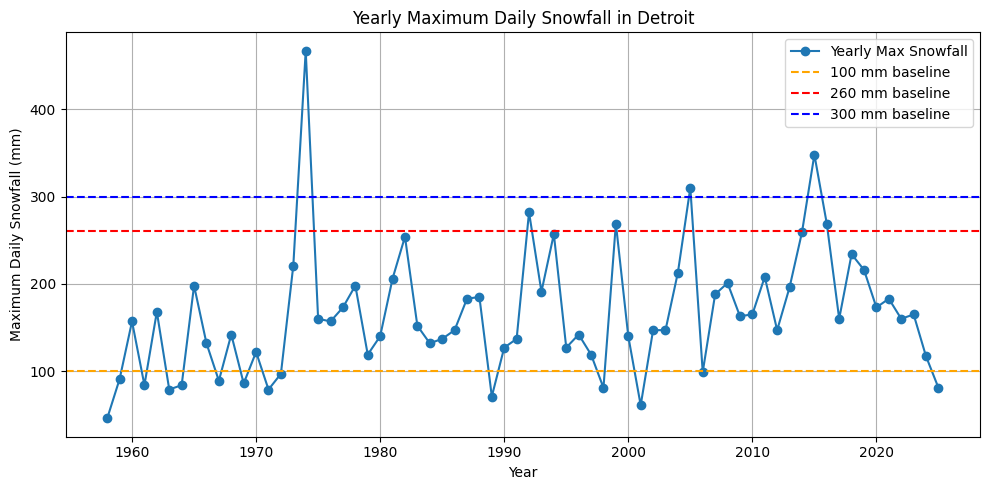

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(yearly_max["year"], yearly_max["SNOW"], marker="o", linestyle="-", label="Yearly Max Snowfall")
plt.axhline(y=100, color="orange", linestyle="--", label="100 mm baseline")
plt.axhline(y=300, color="blue", linestyle="--", label="300 mm baseline")

plt.xlabel("Year")
plt.ylabel("Maximum Daily Snowfall (mm)")
plt.title("Yearly Maximum Daily Snowfall in Detroit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The data may be sorted already, but sort again just to be sure

In [21]:
df_snow = df_snow.sort_values(by="DATE")

Display the first few rows of data.

In [22]:
df_snow.shape

(24360, 3)

In [23]:
df_snow.head()

,DATE,SNOW,year
1515,1958-12-01,0.0,1958
1516,1958-12-02,0.0,1958
1517,1958-12-03,0.0,1958
1518,1958-12-04,0.0,1958
1519,1958-12-05,13.0,1958


In [24]:
df_snow.shape

(24360, 3)

Use this threshold (units are mm) for calculating exceedances

In [25]:
thresh = 100.0
(df_snow["SNOW"] >= thresh).mean()

np.float64(0.005993431855500821)

Plot the data as a time series

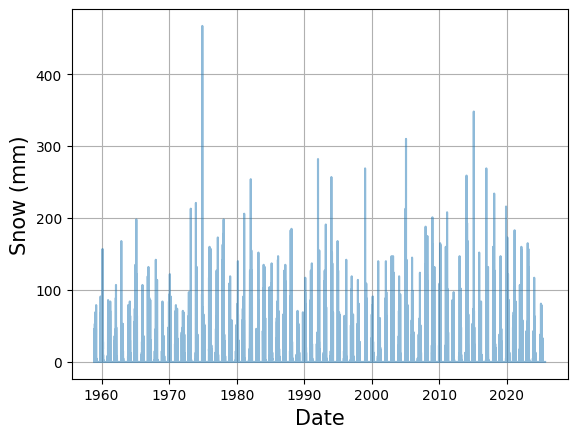

In [26]:
plt.clf()
plt.grid(True)
plt.plot(df_snow["DATE"], df_snow["SNOW"], "-", alpha=0.5)
plt.xlabel("Date", size=15)
plt.ylabel("Snow (mm)", size=15)
plt.show()

Plot the data as a histogram.  A histogram is not useful for studying extreme values.

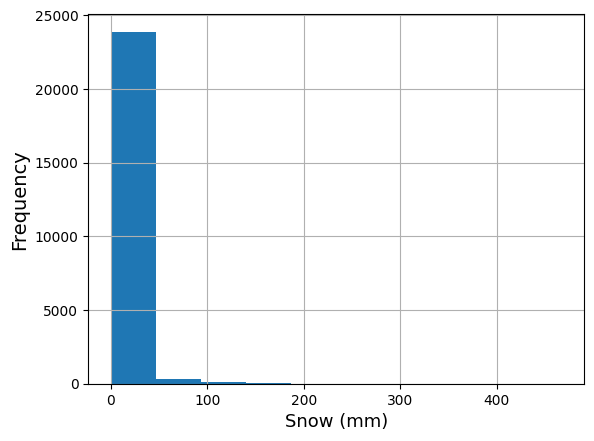

In [27]:
plt.clf()
plt.grid(True)
plt.hist(df_snow["SNOW"])
plt.xlabel("Snow (mm)", size=13)
plt.ylabel("Frequency", size=14)
plt.show()

Plot the data as an (empirical) CDF.  This is not a very helpful approach for judging the structure of the tail of a probability distribution.

Text(0, 0.5, 'Cumulative probability')

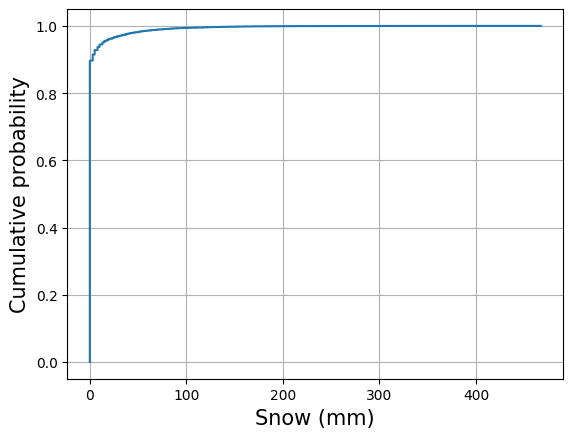

In [28]:
plt.clf()
plt.grid(True)
x = np.sort(df_snow["SNOW"])
p = np.linspace(0, 1, len(x))
plt.plot(x, p, "-")
plt.xlabel("Snow (mm)", size=15)
plt.ylabel("Cumulative probability", size=15)

Plot the data as an (empirical) complementary CDF (also known as the ccdf or survival function)

Text(0, 0.5, 'Complementary cumulative probability')

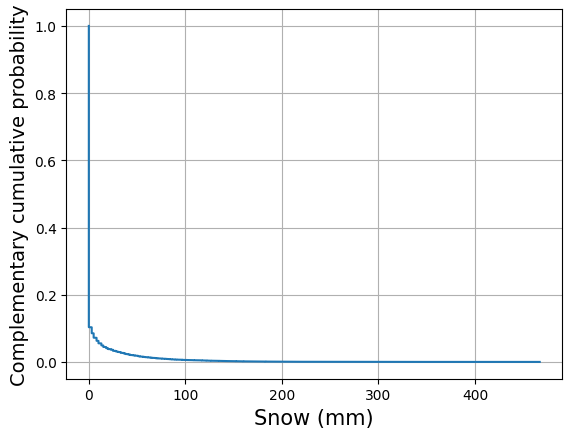

In [29]:
plt.clf()
plt.grid(True)
x = np.sort(df_snow["SNOW"])
p = np.linspace(0, 1, len(x))
plt.plot(x, 1 - p, "-")
plt.xlabel("Snow (mm)", size=15)
plt.ylabel("Complementary cumulative probability", size=14)

Below we generate probability tail plots, assessing goodness of fit of the upper order statistics to either a powerlaw or exponential pattern.  Various upper fractions of the order statistics are used.

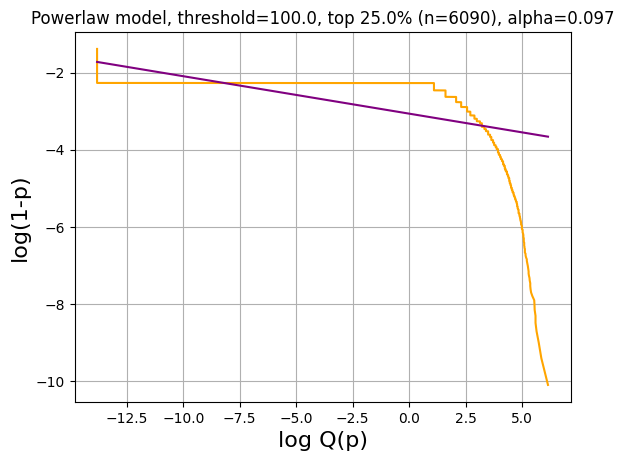

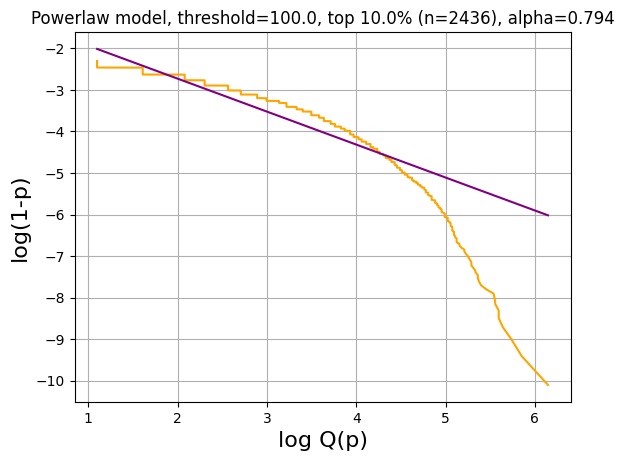

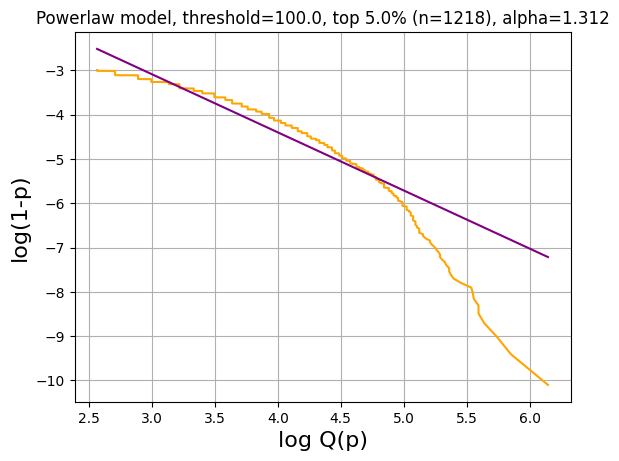

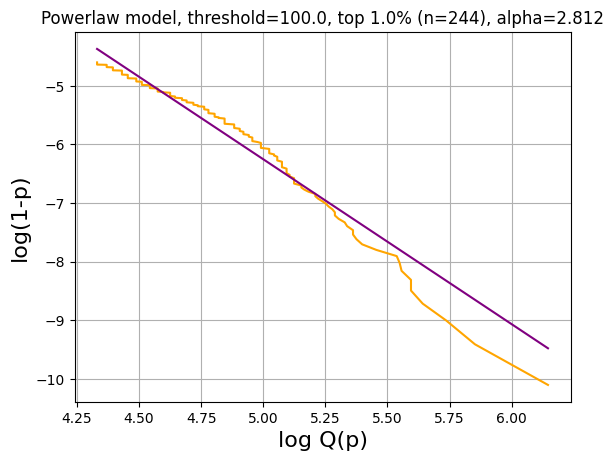

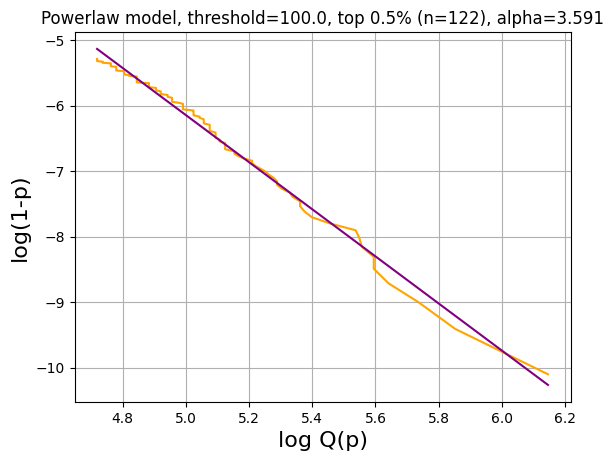

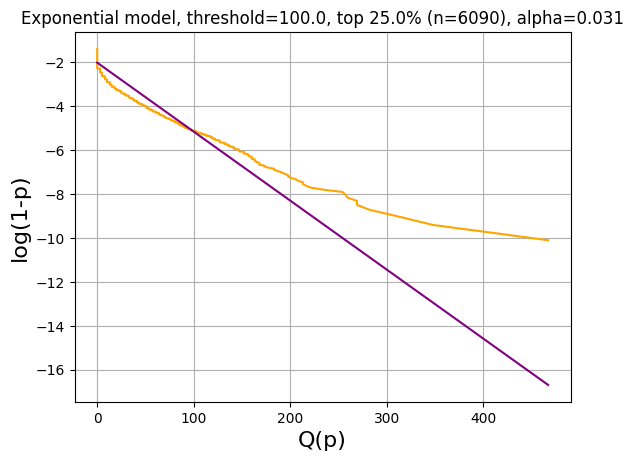

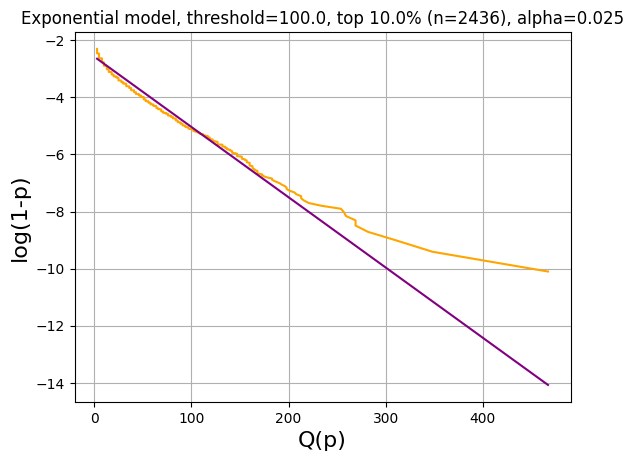

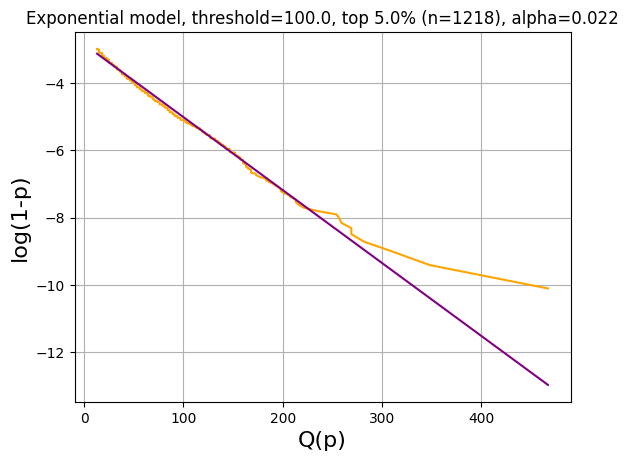

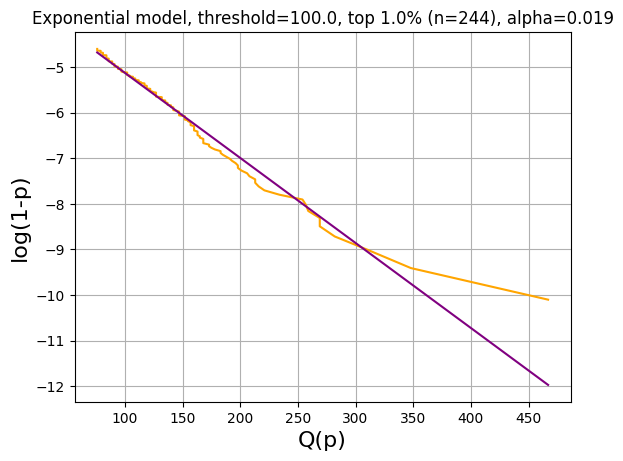

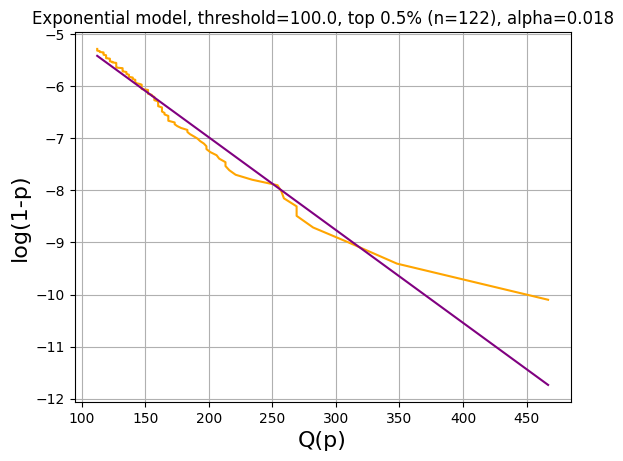

In [30]:
for family in ["powerlaw", "exponential"]:
    for p0 in [0.25, 0.1, 0.05, 0.01, 0.005]:
        plot_tails(df_snow["SNOW"], p0, thresh, family)
        plt.show()

Below is a "Hill plot" suggesting that the distribution might be heavy tailed with a tail index around 3.

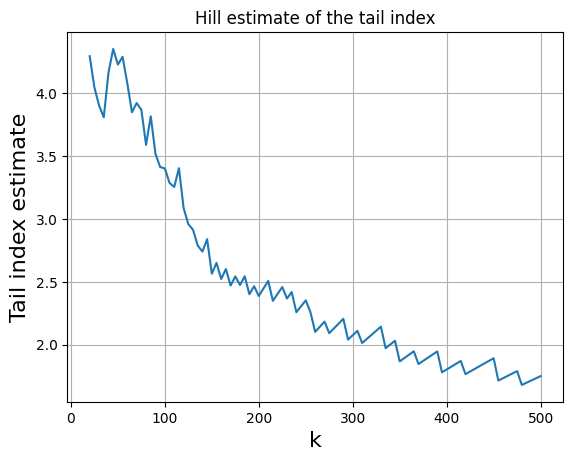

In [31]:
plot_hill(df_snow["SNOW"])

If we make Hill plots of IID data from Gaussian or exponential distributions, the Hill plots do not have any clear flat regions.  Also the tail index estimates are much larger than for the actual precipitation data.

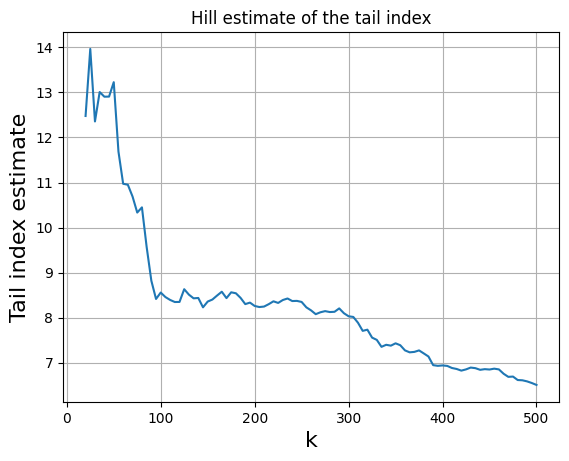

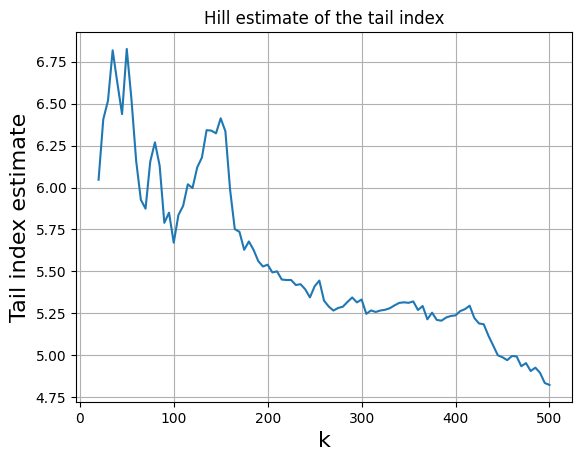

In [32]:
plot_hill(np.random.normal(size=df_snow["SNOW"].size))
plot_hill(np.random.exponential(size=df_snow["SNOW"].size))

Next we fit generalized extreme value distributions to the block (annual) maxima.  The m-returns based on the GEV model are printed and a qq-plot showing the goodness of fit of the GEV to the data is displayed.

   Years      Return
0      5  218.667819
1     10  260.963055
2     20  302.466018
3     50  357.577003
4    100  399.927837
5    500  501.362355
6   1000  546.549589


/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_66641/1303961959.py:13: FutureWarning: The provided callable <function max at 0x107413b00> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  yrmx = dx.groupby("year")["SNOW"].agg(np.max)


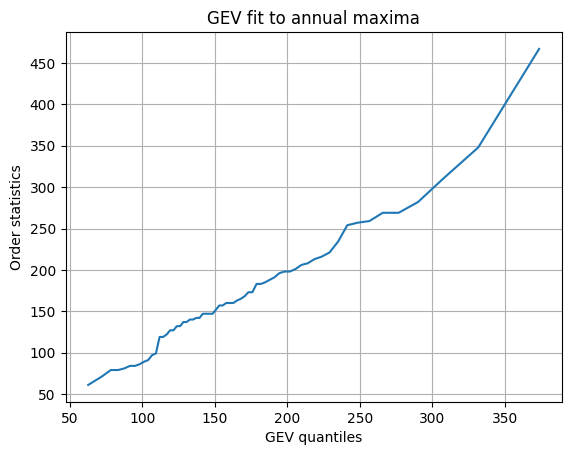

In [33]:
gev_snow = block_max(df_snow)

Below is the shape parameter of the best-fitting GEV to the block maxima.  Due to the parameterization of the GEV used by Scipy, the tail index is -1/shape.

In [34]:
gev_snow.args

(np.float64(-0.030909998026161366),)

In [35]:
-1/gev_snow.args[0]

np.float64(32.351991713284086)

Fit generalized Pareto models to the exceedances

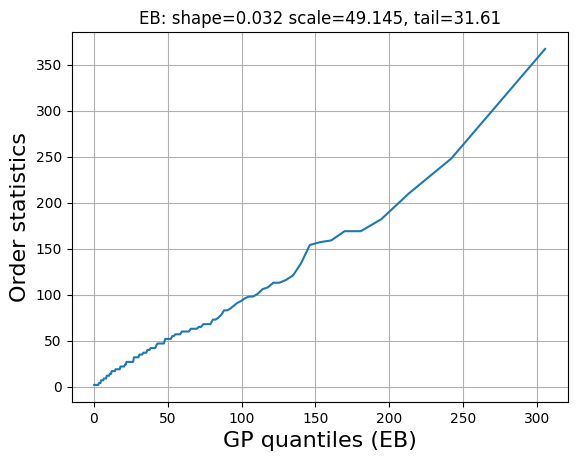

In [36]:
eb = eb_analysis(df_snow["SNOW"], thresh)

Next we calculate m-observation returns based on an exponential and a generalized Pareto model fit to the 24 hour rainfall totals.

In [37]:
yr = np.r_[5, 10, 20, 50, 100, 500, 1000]
cfg = [("exponential", None), ("generalizedpareto", eb)]
for (f,g) in cfg:
    print("\nReturns based on %s:" % f)
    mr = mobs_return(df_snow["SNOW"], 365 * yr, thresh, family=f, gp=g)
    rr = pd.DataFrame({"Years": yr, "MR": mr})
    print(rr)


Returns based on exponential:
Mean = 50.71
   Years          MR
0      5  221.316273
1     10  256.467380
2     20  291.618488
3     50  338.085725
4    100  373.236833
5    500  454.855177
6   1000  490.006285

Returns based on generalizedpareto:
Shape=0.03
Scale=49.14
   Years          MR
0      5  222.129294
1     10  259.277640
2     20  297.249549
3     50  348.740694
4    100  388.695957
5    500  484.918807
6   1000  527.893076


The cell below is a simple demonstration of how to use the gp_estimate function defined above.  Note that there are different parameterizations of the generalized Pareto distribution (this is true of many probability distributions).  Since we are using [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html), here we use the parameterization adopted by scipy, which is also the parameterization shown on [wikipedia](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution).  The shape parameter $\xi$ is the reciprocal of the tail index $\alpha$, i.e. $\alpha = 1/\xi$.

In [38]:
shape = 1/3.
scale = 1

# Generate data and obtain an estimated GPD using the empirical Bayes approach.
eb, z = check_gp_estimate(shape=shape, scale=scale, thresh=0)

# Check that the population and sample medians match (if they don't something is wrong)
print("Sample median =", np.median(z))
print("Population median =", scale*(2**shape - 1) / shape)

# The fitted GPD has this shape parameter
print("Fitted GPD shape parameter: ", eb.args)

# This is the estimated tail index
print("Estimated tail index: ", 1 / eb.args[0])
print("Population tail index: ", 1 / shape)

Sample median = 0.7763569699993758
Population median = 0.7797631496846196
Fitted GPD shape parameter:  (np.float64(0.3370721530150964),)
Estimated tail index:  2.9667238632887396
Population tail index:  3.0


## L moment approaches to heavy tails

Below we calculate the standardized third and fourth L-moment, compare to figure 3 of [this paper](https://www.tandfonline.com/doi/full/10.1080/00031305.2024.2402898).  Arguably, if the standardized fourth L-moment exceeds 0.35 then conventional statistical inference is "disrupted".

In [39]:
lmom.l3(df_snow["SNOW"]) / lmom.l2(df_snow["SNOW"])

np.float64(0.9181103218816149)

In [40]:
lmom.l4(df_snow["SNOW"]) / lmom.l2(df_snow["SNOW"])

np.float64(0.8084478524272372)

For comparison, below we calculate the standardized third and fourth L-moments for Gaussian (normal) and exponential data.

In [41]:
n = int(1e6)

z = np.random.normal(size=n)
print(lmom.l3(z) / lmom.l2(z))
print(lmom.l4(z) / lmom.l2(z))

e = -np.log(np.random.uniform(size=n))
print(lmom.l3(e) / lmom.l2(e))
print(lmom.l4(e) / lmom.l2(e))

-0.00020133847086565532
0.12250984822489608
0.3334372750103854
0.16659743648303355
